**Problem Statement**:
-------------------------

Predicting the right answer for the given question and context.

In [ ]:
# importing all necessary files
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import json
import re
import nltk
import csv


from langdetect import detect
from pickle import dump,load

import tensorflow as tf
import sys
import datetime
import os
import six

from collections import Counter
import string
import re
import sys

W0824 19:10:22.356319 17008 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


## 1. Preprocessing

In [ ]:
train = pd.read_json("SQuAD/train-v1.1.json")
dev = pd.read_json("SQuAD/dev-v1.1.json")

print(train.shape)
print(dev.shape)

In [ ]:
dev.head()

,data,version
0,"{'title': 'Super_Bowl_50', 'paragraphs': [{'co...",1.1
1,"{'title': 'Warsaw', 'paragraphs': [{'context':...",1.1
2,"{'title': 'Normans', 'paragraphs': [{'context'...",1.1
3,"{'title': 'Nikola_Tesla', 'paragraphs': [{'con...",1.1
4,"{'title': 'Computational_complexity_theory', '...",1.1


In [ ]:
# getting train data and dev data into csv file

contexts = []
questions = []
answers_text = []
answers_start = []
title = []
for i in range(train.shape[0]):
    topic = train.iloc[i,0]['paragraphs']
    title_ = train.iloc[i,0]['title']
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question'])
            if len(q_a['answers'])>0 :
                answers_start.append(q_a['answers'][0]['answer_start']) 
                answers_text.append(q_a['answers'][0]['text'])
            else:
                answers_start.append(None)
                answers_text.append(None)
            contexts.append(sub_para['context'])
            title.append(title_)
            
# test data

test_contexts = []
test_questions = []
test_answers_text = []
test_answers_start = []
test_title = []
for i in range(dev.shape[0]):
    topic = dev.iloc[i,0]['paragraphs']
    title_ = dev.iloc[i,0]['title']
    for sub_para in topic:
        for q_a in sub_para['qas']:
            test_questions.append(q_a['question'])
            if len(q_a['answers'])>0 :
                test_answers_start.append(q_a['answers'][0]['answer_start']) 
                test_answers_text.append(q_a['answers'][0]['text'])
            else:
                test_answers_start.append(None)
                test_answers_text.append(None)
            test_contexts.append(sub_para['context'])
            test_title.append(title_)

In [ ]:
train = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "text": answers_text,'title':title})
train.dropna(inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87599 entries, 0 to 87598
Data columns (total 5 columns):
context         87599 non-null object
question        87599 non-null object
answer_start    87599 non-null int64
text            87599 non-null object
title           87599 non-null object
dtypes: int64(1), object(4)
memory usage: 4.0+ MB


In [ ]:
dev = pd.DataFrame({"context":test_contexts, "question": test_questions, "answer_start": test_answers_start, "text": test_answers_text,'title':test_title})
dev.dropna(inplace=True)
dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10570 entries, 0 to 10569
Data columns (total 5 columns):
context         10570 non-null object
question        10570 non-null object
answer_start    10570 non-null int64
text            10570 non-null object
title           10570 non-null object
dtypes: int64(1), object(4)
memory usage: 495.5+ KB


In [ ]:
train.head()

,context,question,answer_start,text,title
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,University_of_Notre_Dame
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,University_of_Notre_Dame
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,University_of_Notre_Dame
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,381,a Marian place of prayer and reflection,University_of_Notre_Dame
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,92,a golden statue of the Virgin Mary,University_of_Notre_Dame


## 2. Data Preprocessing

### 2.1 Text data cleaning

In [ ]:
def decontracted(phrase):
    """
    This function remooves punctuation from given sentence.
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    # string operation
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')

    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase.lower())
    
    return phrase


def tokenize(sentence):
    """
    Returns tokenised words.
    """
    return nltk.word_tokenize(sentence)

def answer_span(context,ans):
    """
    This funtion returns anwer span start index and end index.
    """
    ans_token = tokenize(ans)
    con_token = tokenize(context)
    ans_len = len(ans_token)
    
    if ans_len!=0 and ans_token[0] in con_token:
    
        indices = [i for i, x in enumerate(con_token) if x == ans_token[0]]
        try:

            if(len(indices)>1):
                start = [i for i in indices if (con_token[i:i+ans_len] == ans_token) ]
                end = start[0] + ans_len - 1
                return start[0],end

            else:
                start = con_token.index(ans_token[0])
                end = start + ans_len - 1
                return start,end
        except:
            return -1,-1
    else:
        return -1,-1


1. Context

In [ ]:
# for train data

from tqdm import tqdm
preprocessed_context = []
# tqdm is for printing the status bar
for sentance in tqdm(train["context"].values):
    sent = decontracted(sentance)
    preprocessed_context.append(sent.strip())
    
train["clean_context"] = preprocessed_context
        
# for dev data
from tqdm import tqdm
dev_preprocessed_context = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["context"].values):
    sent = decontracted(sentance)
    dev_preprocessed_context.append(sent.strip())
    
dev["clean_context"] = dev_preprocessed_context

100%|█████████████████████████████████████████████████████████████████████████| 10570/10570 [00:00<00:00, 11661.38it/s]


In [ ]:
preprocessed_context[0]

'architecturally the school has a catholic character atop the main building is gold dome is a golden statue of the virgin mary immediately in front of the main building and facing it is a copper statue of christ with arms upraised with the legend venite ad me omnes next to the main building is the basilica of the sacred heart immediately behind the basilica is the grotto a marian place of prayer and reflection it is a replica of the grotto at lourdes france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 at the end of the main drive and in a direct line that connects through 3 statues and the gold dome is a simple modern stone statue of mary'

2. Qustions

In [ ]:
# for train data

from tqdm import tqdm
preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(train["question"].values):
    sent = decontracted(sentance)
    preprocessed_question.append(sent.strip())
    
train["clean_question"] = preprocessed_question


# for dev data
    
from tqdm import tqdm
dev_preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["question"].values):
    sent = decontracted(sentance)
    dev_preprocessed_question.append(sent.strip())

dev["clean_question"] = dev_preprocessed_question

100%|█████████████████████████████████████████████████████████████████████████| 10570/10570 [00:00<00:00, 56982.19it/s]


In [ ]:
preprocessed_question[:5]

['to whom did the virgin mary allegedly appear in 1858 in lourdes france',
 'what is in front of the notre dame main building',
 'the basilica of the sacred heart at notre dame is beside to which structure',
 'what is the grotto at notre dame',
 'what sits on top of the main building at notre dame']

3. Answers

In [ ]:
# for train data
    
preprocessed_answer = []
# tqdm is for printing the status bar
for sentance in tqdm(train["text"].values):
    sent = decontracted(sentance)
    preprocessed_answer.append(sent.strip())
    
    
train["clean_answer"] = preprocessed_answer

# for dev data
    
dev_preprocessed_answer = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["text"].values):
    sent = decontracted(sentance)
    dev_preprocessed_answer.append(sent.strip())
    
dev["clean_answer"] = dev_preprocessed_answer

100%|█████████████████████████████████████████████████████████████████████████| 10570/10570 [00:00<00:00, 64279.64it/s]


### 2.2 Language Detection

The language of the message is iden-tified and non-English messages are discarded.

In [ ]:
# function for language detction

def get_language(string):
    
    """
    This function returns the language of string. Uses Textblob which internally uses google API. 
    
    This creates problem when you have to check for too many values.
    
    You will get --> 'HTTPError: HTTP Error 429: Too Many Requests'
    
    @return - language
    
    """
    return TextBlob(string).detect_language()


def language(string):
    """
    Not as accurate as TextBlob but gets our work done.
    
    @return - language
    
    """
    return detect(string)

In [ ]:
# for train data

train["language"] = train["clean_context"].apply(language)
print(np.unique(train["language"]))

# for dev data

dev["language"] = dev["clean_context"].apply(language)
print(np.unique(dev["language"]))

['en' 'it' 'pt']
['en']


In [ ]:
train = train[train["language"] == 'en']
print(train.shape)

dev = dev[dev["language"] == 'en']
print(dev.shape)

(87595, 9)
(10570, 9)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87388 entries, 0 to 87598
Data columns (total 11 columns):
context           87388 non-null object
question          87388 non-null object
answer_start      87388 non-null int64
text              87388 non-null object
title             87388 non-null object
clean_context     87388 non-null object
clean_question    87388 non-null object
clean_answer      87388 non-null object
language          87388 non-null object
ans_span          87388 non-null object
exact             87388 non-null int64
dtypes: int64(2), object(9)
memory usage: 8.0+ MB


### 2.3 Calculating ans span for given ans and context

In [ ]:
ans_span = []
for i in range(len(train)):
    s,e = answer_span(train["clean_context"].iloc[i],train["clean_answer"].iloc[i])
    ans_span.append((s,e))
    
print("number of answer not matching context :- ",ans_span.count((-1,-1)))

train["ans_span"] = ans_span

number of answer not matching context :-  0


In [ ]:
ans_span = []
for i in range(len(dev)):
    s,e = answer_span(dev["clean_context"].iloc[i],dev["clean_answer"].iloc[i])
    ans_span.append((s,e))
    
print("number of answer not matching context :- ",ans_span.count((-1,-1)))

dev["ans_span"] = ans_span

number of answer not matching context :-  0


In [ ]:
print(train.shape)
print(dev.shape)

(87388, 11)
(10548, 11)


In [ ]:
train = train[train["ans_span"] != (-1,-1)]
dev = dev[dev["ans_span"] != (-1,-1)]

In [ ]:
print(train.shape)
print(dev.shape)

(87388, 11)
(10548, 11)


## 3. EDA

In [ ]:
# adding context_length ,question_length and answer_length features for eda
train["context_length"] = train["clean_context"].apply(lambda x:len(x.split()))
train["question_length"] = train["clean_question"].apply(lambda x:len(x.split()))
train["answer_length"] = train["clean_answer"].apply(lambda x:len(x.split()))

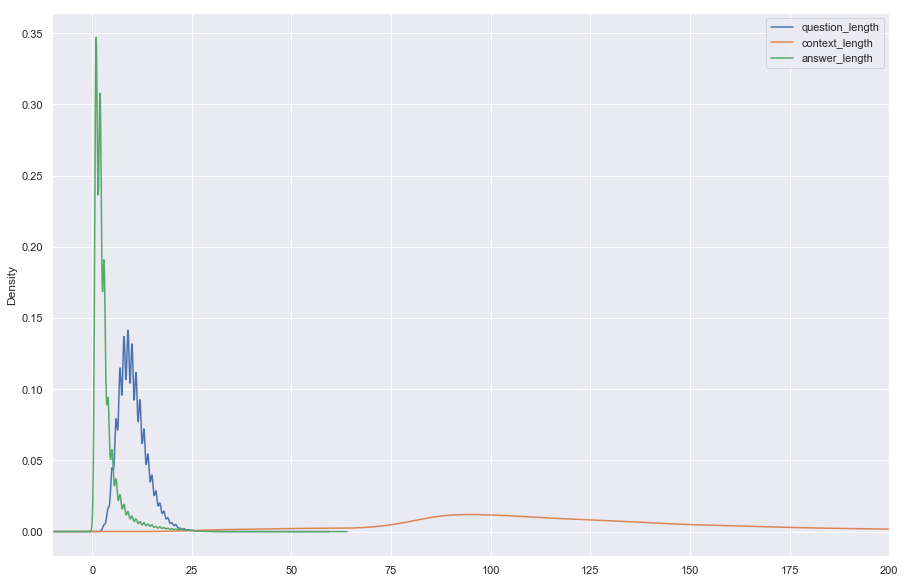

In [ ]:
sns.set()
tf = train[["question_length","context_length","answer_length"]]
tf.plot.kde(figsize=(15,10),xlim=(-10,200))

1. Train Context Length

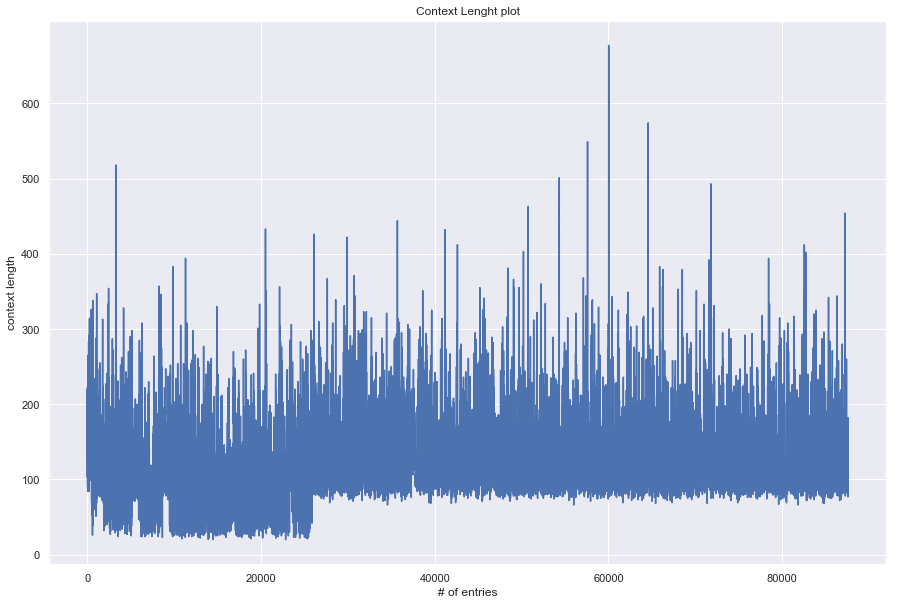

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(train["context_length"])
plt.xlabel("# of entries")
plt.ylabel("context length")
plt.yticks(range(0,700,100))
plt.title("Context Lenght plot")
plt.show()

2. Train Question Length

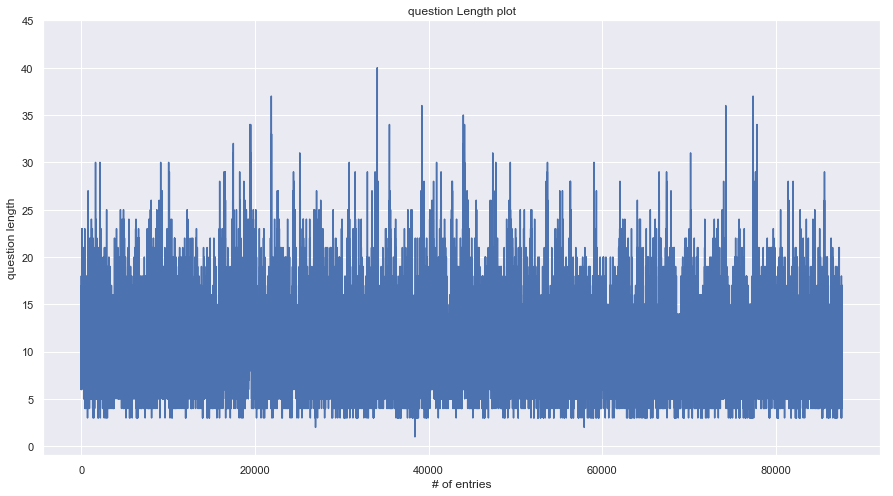

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(train["question_length"])
plt.xlabel("# of entries")
plt.ylabel("question length")
plt.yticks(range(0,50,5))
plt.title("question Length plot")
plt.show()

3. Answer Length plot

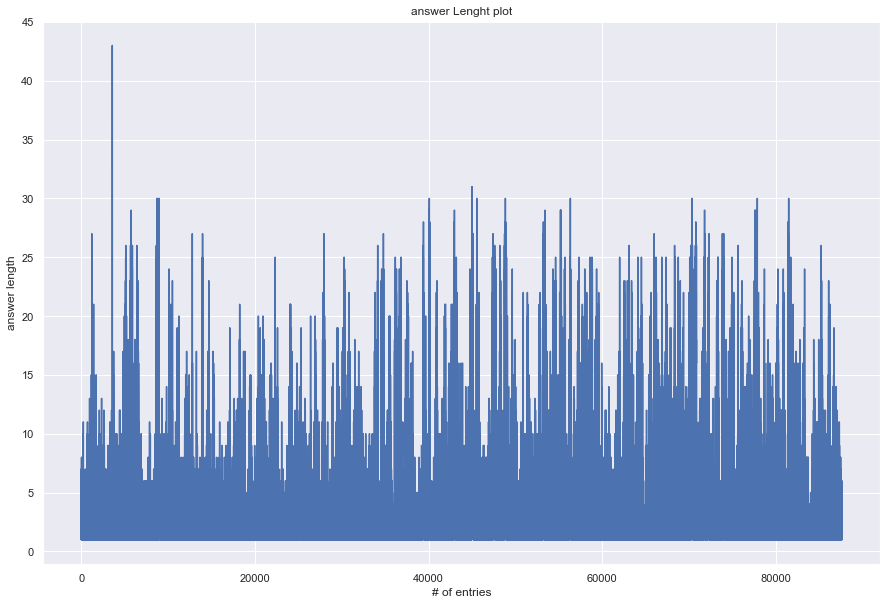

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(train["answer_length"])
plt.xlabel("# of entries")
plt.ylabel("answer length")
plt.yticks(range(0,50,5))
plt.title("answer Lenght plot")
plt.show()

In [ ]:
train["answer_length"].describe()

count    30000.000000
mean         3.305233
std          3.448970
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         31.000000
Name: answer_length, dtype: float64

## 4. Encoding

**If you have files , you can start from here...**

In [ ]:
# train.to_csv("train.csv")
# dev.to_csv("dev.csv")

train = pd.read_csv("train.csv")
dev = pd.read_csv("dev.csv")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample,shuffle

train = resample(train)
train = shuffle(train,n_samples =50000)

train,dev = train_test_split(train,test_size = 0.2)
train,cv = train_test_split(train,test_size=0.25)

print(train.shape)
print(cv.shape)
print(dev.shape)

(30000, 15)
(10000, 15)
(10000, 15)


In [ ]:
# loading already stored embeding matrix and dictionary

with open("embedding.pkl","rb") as f:
    embedding_matrix = load(f)
print("Shpae of embedding matrix is ",embedding_matrix.shape)

with open("word2ix.pkl","rb") as f:
    word2ix = load(f)
    
print(len(word2ix))

Shpae of embedding matrix is  (74621, 300)
74620


In [ ]:
cv.to_csv("data/cv.csv")
dev.to_csv("data/dev.csv")
train.to_csv("data/train.csv")

In [ ]:
# using keras as it is highly optimized.
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.word_index = word2ix

Using TensorFlow backend.


In [ ]:
# word2ix and ix2word dictionary
word2ix = token.word_index
ix2word = dict()

for k,v in word2ix.items():
    ix2word[v] = k
    
print(len(word2ix))
print(len(ix2word))

74620
74620


In [ ]:
from keras.backend import gather
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [ ]:
d = pd.read_table("tags",delimiter = "|",header=None)

pos_tags_list = d[0].values
pos_tags_list = [et.strip() for et in pos_tags_list]
tag_to_num = {tag:i for i, tag in enumerate(sorted(pos_tags_list),1)} 
num_to_tag = {i:tag for i, tag in enumerate(sorted(pos_tags_list),1)}

QUES_LEN = 40
CON_LEN = 680
TAGS = 36


print(len(pos_tags_list))

36


In [ ]:
def exact_lemma(ques_tokens,con_tokens):
    """
    This function returns array of two binary features. Exact match and lemma.
    
    """
    exact = [1 if ecw in ques_tokens else 0 for ecw in con_tokens]
    lemma = [1 if lemmatizer.lemmatize(et, pos="v") in ques_tokens else 0 for et in con_tokens]
    bi = np.array([exact,lemma])
    return np.transpose(bi)


def term_ferquency(tokens):
    """
    This funtion returns term frequecy of every word.
    """
    l = len(tokens)
    tf = [tokens.count(ew)/l for ew in tokens]
    tf = np.array([tokens.count(ew)/l for ew in tokens])
    return np.reshape(tf,(l,-1))


def tags(tokens):
    """
    This function returns POS tags.
    """
    return nltk.pos_tag(tokens)

def pos_ner(tokens):
    """
    This function returns one hot encoded pos/ner tags for each word.
    """
    pos = np.zeros((len(tokens),len(tag_to_num)+1))
    pos_tags = tags(tokens)
    pi,ti = zip(*pos_tags)
    pos[np.arange(len(tokens)),[tag_to_num[i] if i in tag_to_num else 0 for i in ti]] = 1
    return pos  


def tokenize(sentence):
    """
    Returns tokenised words.
    """
    return nltk.word_tokenize(sentence)

def get_glove(tokens):
    """
    This function returns glove vectors for given tokens.
    """
    indices = [word2ix[w] if w in word2ix else 0 for w in tokens]
    return gather(embedding_matrix,indices)
    



def context_question(context,question):
    """
    This function takes context and question and perform various operatons on them.
    """
    con_tokens = tokenize(context)
    ques_tokens = tokenize(question)
    
    # this function returns term frequency of every word in context.
    term_ferq = term_ferquency(con_tokens)
    
    # this function returns matrix of one_hot_enoced pos tags. (tokens_size,33)
    pos_ = pos_ner(con_tokens)
    
    # this function retuns matrix of glove vector. (tokens_size,300)
    glove_ = get_glove(con_tokens)
    
    #exact, lemma binary feature.
    ex_lem = exact_lemma(ques_tokens,con_tokens)
    
    # stack glvoe + pos_ + term_frequency horizontally 300 + 36 + 1 + 2 = 338
    final = tf.concat([glove_,pos_,term_ferq,ex_lem],axis = 1)
    
    # as context_length is fixed to 680. Add zero matrix of size (680 - tokens_size). and stack vertically.
    zeros = tf.zeros((CON_LEN - final.shape.as_list()[0],final.shape.as_list()[1]),dtype=tf.float64)
    
    final = tf.concat([final,zeros],axis=0)
    return final

**POS Tags Feature[One Hot Encoded]**

In [ ]:
train_pos_tag = []
for i in range(len(train)):
    tk = tokenize(train["clean_context"].iloc[i])
    pos = pos_ner(tk)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    train_pos_tag.append(tk)

In [ ]:
# for cv data
cv_pos_tag = []
for i in range(len(cv)):
    tk = tokenize(cv["clean_context"].iloc[i])
    pos = pos_ner(tk)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    cv_pos_tag.append(tk)

In [ ]:
dev_pos_tag = []
for i in range(len(dev)):
    tk = tokenize(dev["clean_context"].iloc[i])
    pos = pos_ner(tk)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    dev_pos_tag.append(tk)

**Term Frequency**

In [ ]:
train_term[5].shape

(78, 1)

In [ ]:
# for train data
train_term = []
for i in range(len(train)):
    tk = tokenize(train["clean_context"].iloc[i])
    pos = term_ferquency(tk)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    train_term.append(tk)

In [ ]:
# for dev data
dev_term = []
for i in range(len(dev)):
    tk = tokenize(dev["clean_context"].iloc[i])
    pos = term_ferquency(tk)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    dev_term.append(tk)

In [ ]:
# for cv data
cv_term = []
for i in range(len(cv)):
    tk = tokenize(cv["clean_context"].iloc[i])
    pos = term_ferquency(tk)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    cv_term.append(tk)

In [ ]:
cv_term[5].shape

(680, 1)

**Exact And Lemma Form [Binary Feature]**

In [ ]:
# for train data
train_excat_lemma = []
for i in tqdm(range(len(train))):
    ques_tokens = tokenize(train["clean_question"].iloc[i])
    con_tokens = tokenize(train["clean_context"].iloc[i])
    pos = exact_lemma(ques_tokens,con_tokens)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    train_excat_lemma.append(tk)

In [ ]:
# for dev data
dev_excat_lemma = []
for i in tqdm(range(len(dev))):
    ques_tokens = tokenize(dev["clean_question"].iloc[i])
    con_tokens = tokenize(dev["clean_context"].iloc[i])
    pos = exact_lemma(ques_tokens,con_tokens)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    dev_excat_lemma.append(tk)

In [ ]:
# for cv data
cv_excat_lemma = []
for i in tqdm(range(len(cv))):
    ques_tokens = tokenize(cv["clean_question"].iloc[i])
    con_tokens = tokenize(cv["clean_context"].iloc[i])
    pos = exact_lemma(ques_tokens,con_tokens)
    p_ = np.zeros((CON_LEN - pos.shape[0],pos.shape[1]))
    tk = np.concatenate((pos,p_))
    cv_excat_lemma.append(tk)

**Total words in train manual -- code**

In [ ]:

 word_vocab = set()

 for ec in train["clean_context"].values:
    word_vocab.update(ec.split())
    
 for ec in train["clean_question"].values:
     word_vocab.update(ec.split())

    
 print("Total unique words in training data are {}".format(len(word_vocab)))



 word2ix = dict()
 ix2word = dict()

 for i,w in enumerate(list(word_vocab),1):
     word2ix[w] = i
     ix2word[i] = w
    
 print(len(word2ix))
 print(len(ix2word))

Total unique words in training data are 77855


In [ ]:
# FIXING Some values
VOCAB_SIZE = len(word2ix) + 1
GLOVE = 300
QUES_LEN = 40
CON_LEN = 680


### 4.1 Encoding

**1. Qustion**

In [ ]:
train_clean_question_sequence = token.texts_to_sequences(train["clean_question"].values)
print(type(train_clean_question_sequence))

dev_clean_question_sequence = token.texts_to_sequences(dev["clean_question"].values)
print(type(dev_clean_question_sequence))

cv_clean_question_sequence = token.texts_to_sequences(cv["clean_question"].values)
print(type(cv_clean_question_sequence))

<class 'list'>
<class 'list'>
<class 'list'>


In [ ]:
# padding sequences
from keras.preprocessing.sequence import pad_sequences

In [ ]:
train_question_sequence = pad_sequences(train_clean_question_sequence,maxlen=QUES_LEN,padding="post")


print("Max Question Sequence length is {}".format(train_question_sequence.shape[1]))

cv_question_sequence = pad_sequences(cv_clean_question_sequence,maxlen=QUES_LEN,padding="post")
dev_question_sequence = pad_sequences(dev_clean_question_sequence,maxlen=QUES_LEN,padding="post")

print(train_question_sequence.shape)
print(cv_question_sequence.shape)
print(dev_question_sequence.shape)


Max Question Sequence length is 40
(30000, 40)
(10000, 40)
(10000, 40)


**2. Context**

In [ ]:
train_clean_context_sequence = token.texts_to_sequences(train["clean_context"].values)
print(type(train_clean_context_sequence))

dev_clean_context_sequence = token.texts_to_sequences(dev["clean_context"].values)
print(type(dev_clean_context_sequence))

cv_clean_context_sequence = token.texts_to_sequences(cv["clean_context"].values)
print(type(cv_clean_context_sequence))

<class 'list'>
<class 'list'>
<class 'list'>


In [ ]:
train_context_sequence = pad_sequences(train_clean_context_sequence,maxlen=CON_LEN)

# fix this value as results may vary during various runs

print("Max context Sequence length is {}".format(train_context_sequence.shape[1]))

cv_context_sequence = pad_sequences(cv_clean_context_sequence,maxlen=CON_LEN)
dev_context_sequence = pad_sequences(dev_clean_context_sequence,maxlen=CON_LEN)

print(train_context_sequence.shape)
print(cv_context_sequence.shape)
print(dev_context_sequence.shape)


Max context Sequence length is 680
(30000, 680)
(10000, 680)
(10000, 680)


**Fix these values as results may vary due to change in train and cv during SPLIT**

* QUES_LEN = 40
* CON_LEN = 677
* VOCAB_SIZE = 77880
* GLOVE = 300

#### 3. Creating Answer Sequences

In [ ]:
train["ans_span"] = train["ans_span"].apply(lambda x :eval(x))
dev["ans_span"] = dev["ans_span"].apply(lambda x :eval(x))
cv["ans_span"] = cv["ans_span"].apply(lambda x :eval(x))

In [ ]:

 y_train = []

 for i in range(len(train)):
    
     s_ = np.zeros(CON_LEN,dtype = "int32")
    
     start,end = train["ans_span"].iloc[i]
     s_[start:end] = 1
     y_train.append(s_)

 y_cv = []
 for i in range(len(cv)):
    
     s_ = np.zeros(CON_LEN,dtype = "int32")
    
     start,end = cv["ans_span"].iloc[i]
     s_[start:end] = 1
     y_cv.append(s_)

              
y_dev_c = []

for i in range(len(dev)):
    
    s_ = np.zeros(CON_LEN,dtype = "int32")
    
    start,end = dev["ans_span"].iloc[i]
    s_[start:end] = 1
    y_dev_c.append(s_)
    

In [ ]:
# for train data
y_train = []

for i in range(len(train)):
    
    s_ = np.zeros(CON_LEN,dtype = "int32")
    e_ = np.zeros(CON_LEN,dtype = "int32")
    
    start,end = train["ans_span"].iloc[i]
    s_[start] = 1
    e_[end] = 1
    y_train.append(np.concatenate((s_,e_)))


# for cv data
y_cv = []

for i in range(len(cv)):
    
    s_ = np.zeros(CON_LEN,dtype = "int32")
    e_ = np.zeros(CON_LEN,dtype = "int32")
    
    start,end = cv["ans_span"].iloc[i]
    s_[start] = 1
    e_[end] = 1
    y_cv.append(np.concatenate((s_,e_)))

                
# for dev data
y_dev = []

for i in range(len(dev)):
    
    s_ = np.zeros(CON_LEN,dtype = "int32")
    e_ = np.zeros(CON_LEN,dtype = "int32")
    
    start,end = dev["ans_span"].iloc[i]
    s_[start] = 1
    e_[end] = 1
    y_dev.append(np.concatenate((s_,e_)))
    

### 4.2 Embedding matrix

In [ ]:
# we are using glove 300d vectors for encoding...

words = pd.read_table("glove/glove.42B.300d/glove.42B.300d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

def vec(w):
    """
    This function returns 300 dimetional vector for a given word.
    """
    return words.loc[w].as_matrix()

In [ ]:
# +1 for zero embedding
VOCAB_SIZE = (len(word2ix)+1)
GLOVE = 300
word_array = words.index.values

print("Shape of embedding matrix is of order ({} x {})".format(VOCAB_SIZE,GLOVE))

Shape of embedding matrix is of order (74621 x 300)


In [ ]:
embedding_matrix = np.zeros((VOCAB_SIZE,GLOVE))

print("Embedding matrix shape is ",embedding_matrix.shape)


for ew in tqdm(word2ix):
    if ew in word_array:
        embedding_matrix[word2ix[ew]] = vec(ew)
        
print("Saving the embedding matrix for future use...")

with open("embedding.pkl","wb") as f:
    dump(embedding_matrix,f)

Embedding matrix shape is  (74621, 300)


100%|██████████████████████████████████████████████████████████████████████████| 74620/74620 [1:25:11<00:00, 13.42it/s]


Saving the embedding matrix for future use...


## 5. Model

In [ ]:
from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Dropout,BatchNormalization,Flatten,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

#### 5.1.1 Embedding - For embedding layer

In [ ]:
class Embedding(tf.keras.Model):
    """
    This class applies embedding layer to given input.
    
    """
    def __init__(self, vocab_size,embedding_matrix , embedding_dim = 300):
        
        super(Embedding,self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False,mask_zero=True)
        
    def call(self, x):
        
        x = self.embedding(x)
        return x

#### 5.1.2 BiLSTM - For bi-directional LSTM

In [ ]:
class BiLSTM(tf.keras.Model):
    """
    This class is for bidirectional LSTM we are going to use.
    """
    
    def __init__(self,num_units):
        
        super(BiLSTM, self).__init__()
        
        self.num_units = num_units
        self.bilstm = Bidirectional(LSTM(num_units,return_sequences=True,recurrent_initializer='glorot_uniform',dropout = 0.3))
        
    def call(self,x):
        
        output = self.bilstm(x)
        return output     

#### 5.1.3 Attention -  Weighted Context Vector

In [ ]:
class Attention(tf.keras.Model):
    
    """
    This class implements a weighted sum attention.

    """
    def __init__(self, units = 1):
        
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        
    def call(self, values):
        
        # values is the output of encoder. shape of values (batch,max_len,units)
        #score shape will be (batch,max_len,1)
        score = self.W(values)

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # for clear understanding please check broadcasting in numpy
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
        

#### 5.1.4 Aligned question Embedding

Alpha is a single dense layer with ReLU nonlinearity.

In [ ]:
class AlignAttention(tf.keras.Model):
    
   
    
    
    def __init__(self, units = 1):
        
        super(AlignAttention, self).__init__()
        
        self.W1 = tf.keras.layers.Dense(units,activation="relu")
        self.W2 = tf.keras.layers.Dense(units,activation="relu")
        
    def call(self,encoder,decoder):
        
        # shape of encoder is (batch_size,encoder_timesteps,encoder_units)
        # shape of decoder (batch_size,decoder_timesteps,decoder_units)
        
        # check for efficient way to transform (64,30,128)) * (64,150,128) ==> (64,150,128)
        
        temporal_tensor = []
        
        for i in range(decoder.shape[1]):
            # for every time slice (64,i,128)
            query = decoder[:,i,:]
            
            # shape (64,128) --> (64,1,128)
            hidden_with_time_axis = tf.expand_dims(query, 1)
            
            # score shape == (batch_size, max_length, 1)
            score = self.W1(encoder) * self.W2(hidden_with_time_axis)
            # attention_weights shape == (batch_size, max_length, 1)
            attention_weights = tf.nn.softmax(score, axis=1)
            
            context_vector = attention_weights * encoder
            # context_vector shape after sum == (batch_size, hidden_size)
            context_vector = tf.reduce_sum(context_vector, axis=1)
            
            temporal_tensor.append(tf.expand_dims(context_vector,axis = 1))
            #batch_,hidden_ = context_vector.shape
            #temporal_tensor.append(tf.reshape(context_vector,(batch_,-1,hidden_)))
        
        # concate all tensor along temporal axis. 
        # return shape should be (batch,decoder_timestep,hidden)
        q_align = tf.concat(temporal_tensor,axis = 1)
                
        return tf.concat([q_align,decoder],axis = 2)

In [ ]:

 in_ = Input(shape=(30,300),batch_size=64)
 en = LSTM(128,return_sequences=True)(in_)
 print(en.shape)


 in_ = Input(shape=(100,300),batch_size=64)
 de = LSTM(128,return_sequences=True)(in_)
 print(de.shape)

 att = AlignAttention()(en,de)
 print(att.shape)

#### 5.1.5 Bilinear Term for probability calculations

In [ ]:
class BilinearSimilarity(tf.keras.Model):
  
    
    def __init__(self,hidden_size):
        
        super(BilinearSimilarity,self).__init__()
        
        self.units = hidden_size * 2
        self.WS = tf.keras.layers.Dense(self.units)
        self.WE = tf.keras.layers.Dense(self.units)
        
        
    def call(self,query,values):
         values = tf.transpose(values,[0,2,1])
        start = self.WS(query)
    
        hidden_start_time_axis = tf.expand_dims(start, -1)
        
        start_ = tf.squeeze(tf.matmul(values,hidden_start_time_axis),-1)
            
        start_ = tf.nn.softmax(start_,axis = 1)
            
        
        end = self.WE(query)

        hidden_end_time_axis = tf.expand_dims(end, -1)
        
        
        end_ = tf.squeeze(tf.matmul(values,hidden_end_time_axis),-1)
        end_ = tf.nn.softmax(end_,axis=1)
        
        prob = tf.concat((start_,end_),axis = 1)
        
        return prob
        
        
class BilinearSimilarityLogits(tf.keras.Model):
   
    
    def __init__(self,hidden_size):
        
        super(BilinearSimilarityLogits,self).__init__()
        
        self.units = hidden_size * 2
        self.WS = tf.keras.layers.Dense(self.units)
        self.WE = tf.keras.layers.Dense(self.units)
        
        
    def call(self,query,values):

        values = tf.transpose(values,[0,2,1])
        start = self.WS(query)
        

        hidden_start_time_axis = tf.expand_dims(start, 1)
        
     
        start_logit = tf.squeeze(tf.matmul(hidden_start_time_axis,values),axis=1)
            

        end = self.WE(query)

        hidden_end_time_axis = tf.expand_dims(end, 1)
      
        end_logit = tf.squeeze(tf.matmul(hidden_end_time_axis,values),axis=1)
        
        logits = tf.concat([start_logit,end_logit],axis=1)
        return logits
        

In [ ]:

 from tensorflow.keras.layers import Dense,Input
 q = Input(shape=(256,),batch_size=64)
 v = Input(shape=(400,256),batch_size=64)
 bln = BilinearSimilarityLogits(128)(q,v)
 bln

#### 5.1.6 Predict

#### 5.1.6 Prediction class

In [ ]:


class Prediction(tf.keras.Model):

    def __init__(self,token_span = 15):
        
        super(Prediction,self).__init__()
        self.token_span = token_span
     
    def call(self,prob):
        

        start_prob = prob[:,:CON_LEN]
        end_prob = prob[:,CON_LEN:]
        
        # do the outer product
        outer = tf.matmul(tf.expand_dims(start_prob, axis=2),tf.expand_dims(end_prob, axis=1))
        
        outer = tf.matrix_band_part(outer, 0, self.token_span)
        
        #print(outer.shape)
        
        # start_position will have shape of (batch_size,)
        start_position = tf.reduce_max(outer, axis=2)
        #end position will have shape of (batch_size,)
        end_position = tf.reduce_max(outer, axis=1)
        
        probab = tf.concat([start_position,end_position],axis=1)
        return probab
        
        # masking start and end position to get y_pred as [0,0,0,1,1,1,0,...]
        # sequence mask will convert to 2D tensor of shape (batch_size,timesteps)
        
        #s_ = tf.sequence_mask(start_position,self.timesteps,dtype=tf.int32)
        #e_ = tf.sequence_mask(end_position,self.timesteps,dtype= tf.int32)
        
        # to get answers from start to end subtract 1 from start_position.
        #s_ = s_ - 1
        
        
        
        # subtract end_postion from start_positions to get in form of array
        # final shape should be (batch_size,timesteps)
        #return tf.subtract(e_,s_)
        

#### 5.1.7 Custom Loss Function

In [ ]:
def logits_loss(y_true,logits):
   
    
    #y_true = tf.cast(y_true,dtype=tf.int32)
    #logits = tf.cast(logits,dtype=tf.float32)

    start_label = y_true[:,:CON_LEN]
    end_label = y_true[:,CON_LEN:]
    
    
    start_logit = logits[:,:CON_LEN]
    end_logit = logits[:,CON_LEN:]
    
    start_loss = tf.keras.backend.categorical_crossentropy(start_label,start_logit)
    end_loss = tf.keras.backend.categorical_crossentropy(end_label,end_logit)
    
#     start_loss = tf.losses.sparse_softmax_cross_entropy(labels=start_label, logits=start_logit)
#     end_loss = tf.losses.sparse_softmax_cross_entropy(labels=end_label, logits=end_logit)
    

    
    loss = start_loss + end_loss
    
    return loss


### 5.2 Building Model

In [ ]:
UNITS = 64

In [ ]:
# model building...

# question embedding
q_input = Input(shape=(QUES_LEN,))
q_emb = Embedding(VOCAB_SIZE,embedding_matrix)(q_input)

# encoder 
q_cont = BiLSTM(UNITS)(q_emb)

# question context
q_cont,_ = Attention()(q_cont) 
print(q_cont.shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 128)


In [ ]:
# context side model

# try to improve AlignAttention performance.
c_input = Input(shape=(CON_LEN,))

# context embedding
c_emb = Embedding(VOCAB_SIZE,embedding_matrix)(c_input)



# exact_match
ex_ = Input(shape=(CON_LEN,2))

# pos tags
pos_ = Input(shape=(CON_LEN,len(tag_to_num)+1))

# term frequency
term_ = Input(shape=(CON_LEN,1)) 

# concatenate input
concat = concatenate([c_emb,ex_,pos_,term_])

c_ = BiLSTM(UNITS)(concat)

print("final output that is fed to bilinear ",c_.shape)

final output that is fed to bilinear  (?, 680, 128)


In [ ]:
# bilinear term
print("Question context shape ",q_cont.shape)
print("final o/p of context ",c_.shape)

logits = BilinearSimilarity(UNITS)(q_cont,c_)
Y_prob = Prediction()(logits)
print("Logits shape ",logits.shape)

Question context shape  (?, 128)
final o/p of context  (?, 680, 128)
Logits shape  (?, 1360)


In [ ]:
model = Model(inputs = [q_input,c_input,ex_,pos_,term_],outputs =Y_prob)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 680)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 300)      22386300    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 680, 300)     22386300    input_19[0][0]                   
__________________________________________________________________________________________________
input_20 (

#### 5.2.1 Generator Function for Data

In [ ]:
from numpy import array
def generator_function(length,batch_size = 64,data_type = 'Train'):
   
    X1, X2,X3,X4,X5, y = list(), list(), list(),list(), list(), list()
    flag = True
    if data_type == 'Val':
        flag = False
    n = 0
 .
    while 1:
        for i in range(length):
            n += 1
            if flag:
                X1.append(train_question_sequence[i])
                X2.append(train_context_sequence[i])
                X3.append(train_excat_lemma[i])
                X4.append(train_pos_tag[i])
                X5.append(train_term[i])
                y.append(y_train[i])
            else:
                X1.append(cv_question_sequence[i])
                X2.append(cv_context_sequence[i])
                X3.append(cv_excat_lemma[i])
                X4.append(cv_pos_tag[i])
                X5.append(cv_term[i])
                y.append(y_cv[i])
            if n== batch_size:
                yield ((array(X1),array(X2),array(X3),array(X4),array(X5)),array(y))
                X1, X2,X3,X4,X5 ,y = list(), list(), list(),list(), list(), list()
                n=0

In [ ]:
from sklearn import metrics
from keras import backend as K
from sklearn.metrics import roc_auc_score


    

In [ ]:
# using tensorboard instance for callbacks
from time import time
from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir="logs_123/{}".format(time()))

# model compilation
model.compile(optimizer="adamax",loss=logits_loss,metrics=['acc'])

In [ ]:
epochs = 25
batch_size = 64
train_length = len(y_train)
cv_length = len(y_cv)
train_steps = train_length//batch_size
cv_steps = cv_length//32

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1,save_best_only=True)
 history = tf.keras.callbacks.History()
from keras_tqdm import TQDMNotebookCallback

In [ ]:
for i in range(epochs):
    print("Epoch {} start at time ".format(i),datetime.now())
    generator = generator_function(train_length,batch_size)
    cv_generator = generator_function(cv_length,32,"cv")
    model.fit_generator(generator, epochs=1, steps_per_epoch=train_steps,verbose=0,callbacks=[tensorboard],validation_data=cv_generator,validation_steps=cv_steps)
    model.save_weights("model_epoch_{}.h5".format(i))

Epoch 0 start at time  2019-08-03 23:44:38.683862
203/312 [==================>...........] - ETA: 5:40 - loss: 5.6976 - acc: 0.312 - ETA: 5:31 - loss: 5.6552 - acc: 0.265 - ETA: 5:16 - loss: 6.0375 - acc: 0.239 - ETA: 5:22 - loss: 5.9348 - acc: 0.242 - ETA: 5:21 - loss: 6.0095 - acc: 0.250 - ETA: 5:25 - loss: 5.9980 - acc: 0.265 - ETA: 5:29 - loss: 5.8977 - acc: 0.272 - ETA: 5:25 - loss: 5.8497 - acc: 0.273 - ETA: 5:23 - loss: 5.7841 - acc: 0.284 - ETA: 5:23 - loss: 5.8302 - acc: 0.287 - ETA: 5:20 - loss: 5.8341 - acc: 0.286 - ETA: 5:20 - loss: 5.8486 - acc: 0.283 - ETA: 5:17 - loss: 5.8379 - acc: 0.288 - ETA: 5:14 - loss: 5.8071 - acc: 0.292 - ETA: 5:11 - loss: 5.8101 - acc: 0.291 - ETA: 5:10 - loss: 5.8884 - acc: 0.287 - ETA: 5:09 - loss: 5.8825 - acc: 0.283 - ETA: 5:08 - loss: 5.8455 - acc: 0.286 - ETA: 5:06 - loss: 5.8377 - acc: 0.287 - ETA: 5:05 - loss: 5.8076 - acc: 0.293 - ETA: 5:03 - loss: 5.8202 - acc: 0.294 - ETA: 5:03 - loss: 5.8370 - acc: 0.291 - ETA: 5:01 - loss: 5.8635 - 

204/312 [==================>...........] - ETA: 6:33 - loss: 5.6182 - acc: 0.281 - ETA: 6:13 - loss: 5.5358 - acc: 0.281 - ETA: 5:57 - loss: 5.8958 - acc: 0.260 - ETA: 5:52 - loss: 5.7939 - acc: 0.257 - ETA: 5:56 - loss: 5.8704 - acc: 0.256 - ETA: 5:58 - loss: 5.8533 - acc: 0.281 - ETA: 5:56 - loss: 5.7417 - acc: 0.290 - ETA: 5:50 - loss: 5.7065 - acc: 0.293 - ETA: 5:43 - loss: 5.6386 - acc: 0.302 - ETA: 5:38 - loss: 5.6706 - acc: 0.300 - ETA: 5:31 - loss: 5.6663 - acc: 0.301 - ETA: 5:27 - loss: 5.6768 - acc: 0.299 - ETA: 5:21 - loss: 5.6801 - acc: 0.302 - ETA: 5:15 - loss: 5.6522 - acc: 0.305 - ETA: 5:11 - loss: 5.6592 - acc: 0.308 - ETA: 5:08 - loss: 5.7441 - acc: 0.300 - ETA: 5:05 - loss: 5.7318 - acc: 0.296 - ETA: 5:01 - loss: 5.6930 - acc: 0.296 - ETA: 4:58 - loss: 5.6864 - acc: 0.297 - ETA: 4:57 - loss: 5.6560 - acc: 0.301 - ETA: 4:54 - loss: 5.6671 - acc: 0.305 - ETA: 4:51 - loss: 5.6817 - acc: 0.304 - ETA: 4:49 - loss: 5.7026 - acc: 0.305 - ETA: 4:47 - loss: 5.7086 - acc: 0.303

312/312 [==============================] - ETA: 1:37 - loss: 5.7304 - acc: 0.292 - ETA: 1:36 - loss: 5.7306 - acc: 0.293 - ETA: 1:35 - loss: 5.7317 - acc: 0.293 - ETA: 1:34 - loss: 5.7266 - acc: 0.294 - ETA: 1:33 - loss: 5.7282 - acc: 0.294 - ETA: 1:32 - loss: 5.7321 - acc: 0.294 - ETA: 1:31 - loss: 5.7369 - acc: 0.293 - ETA: 1:30 - loss: 5.7349 - acc: 0.293 - ETA: 1:29 - loss: 5.7319 - acc: 0.294 - ETA: 1:28 - loss: 5.7351 - acc: 0.294 - ETA: 1:28 - loss: 5.7418 - acc: 0.293 - ETA: 1:27 - loss: 5.7413 - acc: 0.293 - ETA: 1:26 - loss: 5.7472 - acc: 0.292 - ETA: 1:25 - loss: 5.7455 - acc: 0.292 - ETA: 1:24 - loss: 5.7494 - acc: 0.292 - ETA: 1:23 - loss: 5.7503 - acc: 0.292 - ETA: 1:22 - loss: 5.7476 - acc: 0.293 - ETA: 1:21 - loss: 5.7456 - acc: 0.293 - ETA: 1:20 - loss: 5.7474 - acc: 0.294 - ETA: 1:19 - loss: 5.7497 - acc: 0.293 - ETA: 1:18 - loss: 5.7482 - acc: 0.293 - ETA: 1:18 - loss: 5.7474 - acc: 0.294 - ETA: 1:17 - loss: 5.7505 - acc: 0.293 - ETA: 1:16 - loss: 5.7496 - acc: 0.293

204/312 [==================>...........] - ETA: 4:46 - loss: 5.4889 - acc: 0.281 - ETA: 4:35 - loss: 5.2683 - acc: 0.343 - ETA: 4:35 - loss: 5.6493 - acc: 0.291 - ETA: 4:38 - loss: 5.5777 - acc: 0.289 - ETA: 4:35 - loss: 5.6111 - acc: 0.293 - ETA: 4:36 - loss: 5.5807 - acc: 0.317 - ETA: 4:34 - loss: 5.4685 - acc: 0.325 - ETA: 4:31 - loss: 5.4284 - acc: 0.328 - ETA: 4:30 - loss: 5.3222 - acc: 0.336 - ETA: 4:27 - loss: 5.3600 - acc: 0.328 - ETA: 4:26 - loss: 5.3527 - acc: 0.332 - ETA: 4:24 - loss: 5.3733 - acc: 0.333 - ETA: 4:22 - loss: 5.3912 - acc: 0.334 - ETA: 4:21 - loss: 5.3632 - acc: 0.339 - ETA: 4:20 - loss: 5.3724 - acc: 0.343 - ETA: 4:20 - loss: 5.4635 - acc: 0.337 - ETA: 4:19 - loss: 5.4491 - acc: 0.338 - ETA: 4:17 - loss: 5.3970 - acc: 0.338 - ETA: 4:16 - loss: 5.3958 - acc: 0.338 - ETA: 4:16 - loss: 5.3663 - acc: 0.340 - ETA: 4:14 - loss: 5.3893 - acc: 0.343 - ETA: 4:13 - loss: 5.3938 - acc: 0.342 - ETA: 4:12 - loss: 5.4138 - acc: 0.343 - ETA: 4:12 - loss: 5.4226 - acc: 0.343

312/312 [==============================] - ETA: 1:34 - loss: 5.4392 - acc: 0.330 - ETA: 1:33 - loss: 5.4402 - acc: 0.331 - ETA: 1:32 - loss: 5.4413 - acc: 0.331 - ETA: 1:31 - loss: 5.4360 - acc: 0.331 - ETA: 1:30 - loss: 5.4373 - acc: 0.331 - ETA: 1:29 - loss: 5.4411 - acc: 0.331 - ETA: 1:28 - loss: 5.4465 - acc: 0.331 - ETA: 1:27 - loss: 5.4457 - acc: 0.331 - ETA: 1:26 - loss: 5.4432 - acc: 0.332 - ETA: 1:26 - loss: 5.4475 - acc: 0.331 - ETA: 1:25 - loss: 5.4541 - acc: 0.330 - ETA: 1:24 - loss: 5.4533 - acc: 0.330 - ETA: 1:23 - loss: 5.4592 - acc: 0.330 - ETA: 1:22 - loss: 5.4581 - acc: 0.330 - ETA: 1:21 - loss: 5.4620 - acc: 0.329 - ETA: 1:20 - loss: 5.4631 - acc: 0.329 - ETA: 1:19 - loss: 5.4606 - acc: 0.330 - ETA: 1:19 - loss: 5.4586 - acc: 0.330 - ETA: 1:18 - loss: 5.4606 - acc: 0.330 - ETA: 1:17 - loss: 5.4626 - acc: 0.330 - ETA: 1:16 - loss: 5.4613 - acc: 0.330 - ETA: 1:15 - loss: 5.4612 - acc: 0.330 - ETA: 1:14 - loss: 5.4630 - acc: 0.330 - ETA: 1:13 - loss: 5.4624 - acc: 0.329

204/312 [==================>...........] - ETA: 6:33 - loss: 5.1686 - acc: 0.312 - ETA: 5:35 - loss: 4.9958 - acc: 0.375 - ETA: 5:06 - loss: 5.3534 - acc: 0.343 - ETA: 5:01 - loss: 5.3126 - acc: 0.328 - ETA: 4:51 - loss: 5.3400 - acc: 0.325 - ETA: 4:45 - loss: 5.2908 - acc: 0.349 - ETA: 4:41 - loss: 5.1722 - acc: 0.357 - ETA: 4:38 - loss: 5.1386 - acc: 0.351 - ETA: 4:34 - loss: 5.0164 - acc: 0.368 - ETA: 4:30 - loss: 5.0430 - acc: 0.362 - ETA: 4:29 - loss: 5.0324 - acc: 0.366 - ETA: 4:28 - loss: 5.0661 - acc: 0.364 - ETA: 4:26 - loss: 5.0911 - acc: 0.365 - ETA: 4:24 - loss: 5.0748 - acc: 0.368 - ETA: 4:24 - loss: 5.0818 - acc: 0.368 - ETA: 4:24 - loss: 5.1806 - acc: 0.361 - ETA: 4:23 - loss: 5.1694 - acc: 0.358 - ETA: 4:23 - loss: 5.1200 - acc: 0.362 - ETA: 4:21 - loss: 5.1136 - acc: 0.361 - ETA: 4:19 - loss: 5.0821 - acc: 0.364 - ETA: 4:18 - loss: 5.1137 - acc: 0.363 - ETA: 4:16 - loss: 5.1135 - acc: 0.360 - ETA: 4:16 - loss: 5.1321 - acc: 0.362 - ETA: 4:14 - loss: 5.1399 - acc: 0.365

312/312 [==============================] - ETA: 1:33 - loss: 5.1687 - acc: 0.352 - ETA: 1:32 - loss: 5.1704 - acc: 0.353 - ETA: 1:31 - loss: 5.1712 - acc: 0.353 - ETA: 1:31 - loss: 5.1660 - acc: 0.353 - ETA: 1:30 - loss: 5.1671 - acc: 0.353 - ETA: 1:29 - loss: 5.1708 - acc: 0.353 - ETA: 1:28 - loss: 5.1768 - acc: 0.353 - ETA: 1:27 - loss: 5.1764 - acc: 0.353 - ETA: 1:26 - loss: 5.1743 - acc: 0.353 - ETA: 1:25 - loss: 5.1788 - acc: 0.352 - ETA: 1:25 - loss: 5.1857 - acc: 0.352 - ETA: 1:24 - loss: 5.1841 - acc: 0.352 - ETA: 1:23 - loss: 5.1898 - acc: 0.352 - ETA: 1:22 - loss: 5.1887 - acc: 0.351 - ETA: 1:21 - loss: 5.1937 - acc: 0.351 - ETA: 1:20 - loss: 5.1950 - acc: 0.351 - ETA: 1:19 - loss: 5.1925 - acc: 0.352 - ETA: 1:18 - loss: 5.1905 - acc: 0.352 - ETA: 1:17 - loss: 5.1928 - acc: 0.352 - ETA: 1:17 - loss: 5.1947 - acc: 0.352 - ETA: 1:16 - loss: 5.1935 - acc: 0.351 - ETA: 1:15 - loss: 5.1929 - acc: 0.351 - ETA: 1:14 - loss: 5.1939 - acc: 0.351 - ETA: 1:13 - loss: 5.1936 - acc: 0.351

204/312 [==================>...........] - ETA: 5:35 - loss: 4.8525 - acc: 0.437 - ETA: 5:10 - loss: 4.6185 - acc: 0.453 - ETA: 5:01 - loss: 4.9479 - acc: 0.427 - ETA: 5:03 - loss: 4.9672 - acc: 0.398 - ETA: 5:00 - loss: 5.0262 - acc: 0.381 - ETA: 4:59 - loss: 5.0191 - acc: 0.380 - ETA: 4:51 - loss: 4.9026 - acc: 0.379 - ETA: 4:49 - loss: 4.8720 - acc: 0.378 - ETA: 4:45 - loss: 4.7478 - acc: 0.392 - ETA: 4:43 - loss: 4.7621 - acc: 0.393 - ETA: 4:42 - loss: 4.7354 - acc: 0.406 - ETA: 4:39 - loss: 4.7974 - acc: 0.403 - ETA: 4:38 - loss: 4.8196 - acc: 0.399 - ETA: 4:39 - loss: 4.8197 - acc: 0.397 - ETA: 4:37 - loss: 4.8378 - acc: 0.397 - ETA: 4:34 - loss: 4.9406 - acc: 0.388 - ETA: 4:34 - loss: 4.9252 - acc: 0.387 - ETA: 4:33 - loss: 4.8749 - acc: 0.392 - ETA: 4:33 - loss: 4.8663 - acc: 0.393 - ETA: 4:34 - loss: 4.8349 - acc: 0.398 - ETA: 4:32 - loss: 4.8748 - acc: 0.397 - ETA: 4:30 - loss: 4.8770 - acc: 0.397 - ETA: 4:29 - loss: 4.9014 - acc: 0.396 - ETA: 4:28 - loss: 4.9156 - acc: 0.398

312/312 [==============================] - ETA: 1:39 - loss: 4.9370 - acc: 0.373 - ETA: 1:38 - loss: 4.9395 - acc: 0.374 - ETA: 1:37 - loss: 4.9399 - acc: 0.374 - ETA: 1:36 - loss: 4.9343 - acc: 0.374 - ETA: 1:35 - loss: 4.9345 - acc: 0.374 - ETA: 1:34 - loss: 4.9379 - acc: 0.374 - ETA: 1:33 - loss: 4.9442 - acc: 0.374 - ETA: 1:32 - loss: 4.9446 - acc: 0.374 - ETA: 1:31 - loss: 4.9432 - acc: 0.374 - ETA: 1:30 - loss: 4.9473 - acc: 0.374 - ETA: 1:29 - loss: 4.9544 - acc: 0.373 - ETA: 1:29 - loss: 4.9526 - acc: 0.373 - ETA: 1:28 - loss: 4.9586 - acc: 0.373 - ETA: 1:27 - loss: 4.9575 - acc: 0.373 - ETA: 1:26 - loss: 4.9628 - acc: 0.372 - ETA: 1:25 - loss: 4.9641 - acc: 0.372 - ETA: 1:24 - loss: 4.9613 - acc: 0.373 - ETA: 1:23 - loss: 4.9593 - acc: 0.374 - ETA: 1:22 - loss: 4.9616 - acc: 0.373 - ETA: 1:21 - loss: 4.9632 - acc: 0.373 - ETA: 1:21 - loss: 4.9622 - acc: 0.373 - ETA: 1:20 - loss: 4.9629 - acc: 0.372 - ETA: 1:19 - loss: 4.9643 - acc: 0.372 - ETA: 1:18 - loss: 4.9639 - acc: 0.372

204/312 [==================>...........] - ETA: 4:37 - loss: 4.6187 - acc: 0.343 - ETA: 4:40 - loss: 4.3527 - acc: 0.406 - ETA: 4:42 - loss: 4.6953 - acc: 0.395 - ETA: 4:39 - loss: 4.7458 - acc: 0.382 - ETA: 4:34 - loss: 4.7935 - acc: 0.381 - ETA: 4:33 - loss: 4.8104 - acc: 0.395 - ETA: 4:35 - loss: 4.7006 - acc: 0.397 - ETA: 4:31 - loss: 4.6740 - acc: 0.398 - ETA: 4:28 - loss: 4.5494 - acc: 0.416 - ETA: 4:26 - loss: 4.5532 - acc: 0.415 - ETA: 4:27 - loss: 4.5262 - acc: 0.429 - ETA: 4:25 - loss: 4.5754 - acc: 0.427 - ETA: 4:25 - loss: 4.5985 - acc: 0.425 - ETA: 4:23 - loss: 4.6018 - acc: 0.424 - ETA: 4:22 - loss: 4.6193 - acc: 0.420 - ETA: 4:21 - loss: 4.7187 - acc: 0.414 - ETA: 4:21 - loss: 4.7043 - acc: 0.413 - ETA: 4:20 - loss: 4.6626 - acc: 0.414 - ETA: 4:20 - loss: 4.6484 - acc: 0.412 - ETA: 4:19 - loss: 4.6151 - acc: 0.417 - ETA: 4:19 - loss: 4.6566 - acc: 0.413 - ETA: 4:18 - loss: 4.6550 - acc: 0.411 - ETA: 4:17 - loss: 4.6864 - acc: 0.413 - ETA: 4:17 - loss: 4.7006 - acc: 0.416

312/312 [==============================] - ETA: 1:36 - loss: 4.7257 - acc: 0.393 - ETA: 1:35 - loss: 4.7286 - acc: 0.393 - ETA: 1:34 - loss: 4.7294 - acc: 0.394 - ETA: 1:34 - loss: 4.7239 - acc: 0.394 - ETA: 1:33 - loss: 4.7250 - acc: 0.394 - ETA: 1:32 - loss: 4.7286 - acc: 0.394 - ETA: 1:31 - loss: 4.7348 - acc: 0.394 - ETA: 1:30 - loss: 4.7353 - acc: 0.394 - ETA: 1:29 - loss: 4.7340 - acc: 0.394 - ETA: 1:28 - loss: 4.7381 - acc: 0.393 - ETA: 1:27 - loss: 4.7454 - acc: 0.393 - ETA: 1:26 - loss: 4.7433 - acc: 0.393 - ETA: 1:25 - loss: 4.7491 - acc: 0.392 - ETA: 1:24 - loss: 4.7475 - acc: 0.392 - ETA: 1:24 - loss: 4.7537 - acc: 0.392 - ETA: 1:23 - loss: 4.7546 - acc: 0.392 - ETA: 1:22 - loss: 4.7517 - acc: 0.393 - ETA: 1:21 - loss: 4.7501 - acc: 0.393 - ETA: 1:20 - loss: 4.7528 - acc: 0.392 - ETA: 1:19 - loss: 4.7548 - acc: 0.392 - ETA: 1:18 - loss: 4.7534 - acc: 0.392 - ETA: 1:17 - loss: 4.7542 - acc: 0.392 - ETA: 1:16 - loss: 4.7549 - acc: 0.392 - ETA: 1:15 - loss: 4.7550 - acc: 0.392

204/312 [==================>...........] - ETA: 5:56 - loss: 4.3777 - acc: 0.406 - ETA: 6:00 - loss: 4.1499 - acc: 0.421 - ETA: 5:43 - loss: 4.5173 - acc: 0.416 - ETA: 5:24 - loss: 4.5714 - acc: 0.375 - ETA: 5:11 - loss: 4.6341 - acc: 0.381 - ETA: 5:03 - loss: 4.6489 - acc: 0.395 - ETA: 5:04 - loss: 4.5392 - acc: 0.401 - ETA: 5:01 - loss: 4.4983 - acc: 0.402 - ETA: 4:58 - loss: 4.3692 - acc: 0.420 - ETA: 4:54 - loss: 4.3561 - acc: 0.421 - ETA: 4:50 - loss: 4.3101 - acc: 0.437 - ETA: 4:48 - loss: 4.3620 - acc: 0.437 - ETA: 4:46 - loss: 4.3676 - acc: 0.435 - ETA: 4:45 - loss: 4.3706 - acc: 0.435 - ETA: 4:42 - loss: 4.3976 - acc: 0.429 - ETA: 4:42 - loss: 4.4922 - acc: 0.423 - ETA: 4:41 - loss: 4.4739 - acc: 0.422 - ETA: 4:38 - loss: 4.4366 - acc: 0.423 - ETA: 4:36 - loss: 4.4117 - acc: 0.424 - ETA: 4:34 - loss: 4.3844 - acc: 0.428 - ETA: 4:32 - loss: 4.4343 - acc: 0.424 - ETA: 4:31 - loss: 4.4279 - acc: 0.423 - ETA: 4:29 - loss: 4.4581 - acc: 0.423 - ETA: 4:29 - loss: 4.4699 - acc: 0.425

312/312 [==============================] - ETA: 1:43 - loss: 4.4950 - acc: 0.418 - ETA: 1:43 - loss: 4.4990 - acc: 0.419 - ETA: 1:42 - loss: 4.4997 - acc: 0.419 - ETA: 1:41 - loss: 4.4942 - acc: 0.419 - ETA: 1:40 - loss: 4.4951 - acc: 0.419 - ETA: 1:39 - loss: 4.4985 - acc: 0.419 - ETA: 1:38 - loss: 4.5042 - acc: 0.418 - ETA: 1:37 - loss: 4.5053 - acc: 0.419 - ETA: 1:36 - loss: 4.5045 - acc: 0.419 - ETA: 1:35 - loss: 4.5089 - acc: 0.418 - ETA: 1:34 - loss: 4.5160 - acc: 0.418 - ETA: 1:33 - loss: 4.5139 - acc: 0.418 - ETA: 1:32 - loss: 4.5188 - acc: 0.418 - ETA: 1:31 - loss: 4.5163 - acc: 0.418 - ETA: 1:31 - loss: 4.5223 - acc: 0.417 - ETA: 1:30 - loss: 4.5234 - acc: 0.417 - ETA: 1:29 - loss: 4.5204 - acc: 0.418 - ETA: 1:28 - loss: 4.5185 - acc: 0.418 - ETA: 1:27 - loss: 4.5218 - acc: 0.418 - ETA: 1:26 - loss: 4.5239 - acc: 0.418 - ETA: 1:25 - loss: 4.5220 - acc: 0.418 - ETA: 1:24 - loss: 4.5241 - acc: 0.418 - ETA: 1:23 - loss: 4.5246 - acc: 0.418 - ETA: 1:22 - loss: 4.5250 - acc: 0.418

204/312 [==================>...........] - ETA: 5:23 - loss: 4.2166 - acc: 0.500 - ETA: 5:27 - loss: 3.9053 - acc: 0.484 - ETA: 5:22 - loss: 4.2176 - acc: 0.468 - ETA: 5:13 - loss: 4.3161 - acc: 0.421 - ETA: 5:07 - loss: 4.4026 - acc: 0.418 - ETA: 5:02 - loss: 4.4104 - acc: 0.437 - ETA: 4:56 - loss: 4.2991 - acc: 0.446 - ETA: 4:50 - loss: 4.2661 - acc: 0.445 - ETA: 4:49 - loss: 4.1519 - acc: 0.458 - ETA: 4:48 - loss: 4.1363 - acc: 0.456 - ETA: 4:44 - loss: 4.1196 - acc: 0.463 - ETA: 4:43 - loss: 4.1609 - acc: 0.460 - ETA: 4:41 - loss: 4.1717 - acc: 0.461 - ETA: 4:42 - loss: 4.1667 - acc: 0.457 - ETA: 4:41 - loss: 4.2115 - acc: 0.454 - ETA: 4:39 - loss: 4.3058 - acc: 0.447 - ETA: 4:38 - loss: 4.2876 - acc: 0.446 - ETA: 4:38 - loss: 4.2527 - acc: 0.447 - ETA: 4:39 - loss: 4.2393 - acc: 0.444 - ETA: 4:40 - loss: 4.2041 - acc: 0.450 - ETA: 4:38 - loss: 4.2554 - acc: 0.447 - ETA: 4:37 - loss: 4.2518 - acc: 0.446 - ETA: 4:36 - loss: 4.2791 - acc: 0.448 - ETA: 4:36 - loss: 4.3027 - acc: 0.449

312/312 [==============================] - ETA: 1:42 - loss: 4.3244 - acc: 0.431 - ETA: 1:41 - loss: 4.3287 - acc: 0.431 - ETA: 1:40 - loss: 4.3292 - acc: 0.431 - ETA: 1:39 - loss: 4.3238 - acc: 0.432 - ETA: 1:38 - loss: 4.3245 - acc: 0.432 - ETA: 1:37 - loss: 4.3280 - acc: 0.432 - ETA: 1:36 - loss: 4.3346 - acc: 0.431 - ETA: 1:35 - loss: 4.3353 - acc: 0.431 - ETA: 1:34 - loss: 4.3347 - acc: 0.431 - ETA: 1:33 - loss: 4.3388 - acc: 0.431 - ETA: 1:32 - loss: 4.3465 - acc: 0.431 - ETA: 1:31 - loss: 4.3445 - acc: 0.431 - ETA: 1:30 - loss: 4.3501 - acc: 0.431 - ETA: 1:29 - loss: 4.3475 - acc: 0.431 - ETA: 1:28 - loss: 4.3537 - acc: 0.430 - ETA: 1:27 - loss: 4.3555 - acc: 0.430 - ETA: 1:26 - loss: 4.3530 - acc: 0.431 - ETA: 1:25 - loss: 4.3512 - acc: 0.431 - ETA: 1:24 - loss: 4.3548 - acc: 0.431 - ETA: 1:24 - loss: 4.3565 - acc: 0.431 - ETA: 1:23 - loss: 4.3546 - acc: 0.431 - ETA: 1:22 - loss: 4.3568 - acc: 0.431 - ETA: 1:21 - loss: 4.3571 - acc: 0.431 - ETA: 1:20 - loss: 4.3569 - acc: 0.431

204/312 [==================>...........] - ETA: 6:25 - loss: 3.7982 - acc: 0.406 - ETA: 5:57 - loss: 3.6529 - acc: 0.453 - ETA: 5:44 - loss: 3.9764 - acc: 0.458 - ETA: 5:21 - loss: 4.0874 - acc: 0.429 - ETA: 5:10 - loss: 4.1936 - acc: 0.431 - ETA: 5:03 - loss: 4.2159 - acc: 0.453 - ETA: 5:00 - loss: 4.1005 - acc: 0.464 - ETA: 4:53 - loss: 4.0585 - acc: 0.468 - ETA: 4:48 - loss: 3.9489 - acc: 0.482 - ETA: 4:45 - loss: 3.9398 - acc: 0.478 - ETA: 4:40 - loss: 3.9024 - acc: 0.485 - ETA: 4:39 - loss: 3.9532 - acc: 0.481 - ETA: 4:37 - loss: 3.9581 - acc: 0.478 - ETA: 4:35 - loss: 3.9645 - acc: 0.475 - ETA: 4:34 - loss: 4.0089 - acc: 0.470 - ETA: 4:31 - loss: 4.0883 - acc: 0.466 - ETA: 4:29 - loss: 4.0708 - acc: 0.463 - ETA: 4:27 - loss: 4.0411 - acc: 0.465 - ETA: 4:25 - loss: 4.0164 - acc: 0.468 - ETA: 4:23 - loss: 3.9775 - acc: 0.475 - ETA: 4:21 - loss: 4.0345 - acc: 0.471 - ETA: 4:21 - loss: 4.0339 - acc: 0.468 - ETA: 4:20 - loss: 4.0613 - acc: 0.468 - ETA: 4:20 - loss: 4.0776 - acc: 0.470

312/312 [==============================] - ETA: 1:40 - loss: 4.0979 - acc: 0.453 - ETA: 1:40 - loss: 4.1026 - acc: 0.453 - ETA: 1:39 - loss: 4.1031 - acc: 0.453 - ETA: 1:38 - loss: 4.0975 - acc: 0.454 - ETA: 1:37 - loss: 4.0981 - acc: 0.453 - ETA: 1:36 - loss: 4.1015 - acc: 0.453 - ETA: 1:35 - loss: 4.1075 - acc: 0.453 - ETA: 1:34 - loss: 4.1078 - acc: 0.453 - ETA: 1:33 - loss: 4.1074 - acc: 0.453 - ETA: 1:32 - loss: 4.1108 - acc: 0.453 - ETA: 1:31 - loss: 4.1191 - acc: 0.452 - ETA: 1:30 - loss: 4.1170 - acc: 0.452 - ETA: 1:29 - loss: 4.1224 - acc: 0.451 - ETA: 1:28 - loss: 4.1192 - acc: 0.451 - ETA: 1:27 - loss: 4.1248 - acc: 0.451 - ETA: 1:26 - loss: 4.1264 - acc: 0.451 - ETA: 1:25 - loss: 4.1232 - acc: 0.452 - ETA: 1:24 - loss: 4.1218 - acc: 0.452 - ETA: 1:23 - loss: 4.1257 - acc: 0.451 - ETA: 1:22 - loss: 4.1273 - acc: 0.451 - ETA: 1:21 - loss: 4.1259 - acc: 0.451 - ETA: 1:21 - loss: 4.1285 - acc: 0.451 - ETA: 1:20 - loss: 4.1282 - acc: 0.451 - ETA: 1:19 - loss: 4.1284 - acc: 0.450

KeyboardInterrupt: 

## 6. Evaluation

In [ ]:
dev_excat_lemma_ = np.array(dev_excat_lemma)
dev_pos_tag_ = np.array(dev_pos_tag)
dev_term_ = np.array(dev_term)

for i in [dev_question_sequence,dev_context_sequence,dev_excat_lemma_,dev_pos_tag_,dev_term_]:
    print(type(i),i.shape)

<class 'numpy.ndarray'> (10000, 40)
<class 'numpy.ndarray'> (10000, 680)
<class 'numpy.ndarray'> (10000, 680, 2)
<class 'numpy.ndarray'> (10000, 680, 37)
<class 'numpy.ndarray'> (10000, 680, 1)


**Micro F1-Score and Accuracy**

In [ ]:
y_ = model.predict([dev_question_sequence,dev_context_sequence,dev_excat_lemma_,dev_pos_tag_,dev_term_])

In [ ]:
y_.shape

(10000, 1360)

In [ ]:
start_pred = []
end_pred = []
for i in range(10000):
    start_pred.append(np.argmax(y_[i,:CON_LEN]))
    end_pred.append(np.argmax(y_[i,CON_LEN:]))
    
start = []
end = []
for i in range(10000):
    start.append(np.argmax(y_dev[i,:CON_LEN]))
    end.append(np.argmax(y_dev[i,CON_LEN:]))

**Lets check how much it matches with original**

In [ ]:
print(start_pred[100:120])
print(end_pred[100:120])

[11, 46, 20, 69, 0, 6, 7, 38, 33, 19, 0, 1, 123, 123, 67, 23, 31, 59, 95, 18]
[13, 46, 20, 73, 1, 6, 7, 39, 33, 21, 0, 1, 124, 124, 67, 25, 31, 59, 95, 19]


In [ ]:
print(start[100:120])
print(end[100:120])

[11, 46, 20, 69, 0, 34, 4, 33, 51, 19, 0, 196, 145, 124, 67, 27, 34, 51, 95, 4]
[11, 46, 21, 73, 1, 34, 4, 34, 52, 22, 0, 196, 146, 124, 68, 28, 34, 56, 95, 5]


In [ ]:
y_predicted = np.zeros((10000,680))
for i in range(10000):
    y_predicted[i,start_pred[i]:end_pred[i]+1] = 1
    
y_test = np.zeros((10000,680))
for i in range(10000):
    y_test[i,start[i]:end[i]+1] = 1

In [ ]:
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score,accuracy_score,precision_score
print("Micro f1-score on test data is ",f1_score(y_test,y_predicted,average="micro"))
print("Macro f1-score on test data is ",f1_score(y_test,y_predicted,average="macro"))
print("Accuracy on test data is ",accuracy_score(y_test,y_predicted))

Micro f1-score on test data is  0.4033550243615317
Macro f1-score on test data is  0.30633713774622445
Accuracy on test data is  0.2868
